Stein Unbiased Risk Estimator
=============================

*Important:* Please read the [installation page](http://gpeyre.github.io/numerical-tours/installation_python/) for details about how to install the toolboxes.
$\newcommand{\dotp}[2]{\langle #1, #2 \rangle}$
$\newcommand{\enscond}[2]{\lbrace #1, #2 \rbrace}$
$\newcommand{\pd}[2]{ \frac{ \partial #1}{\partial #2} }$
$\newcommand{\umin}[1]{\underset{#1}{\min}\;}$
$\newcommand{\umax}[1]{\underset{#1}{\max}\;}$
$\newcommand{\umin}[1]{\underset{#1}{\min}\;}$
$\newcommand{\uargmin}[1]{\underset{#1}{argmin}\;}$
$\newcommand{\norm}[1]{\|#1\|}$
$\newcommand{\abs}[1]{\left|#1\right|}$
$\newcommand{\choice}[1]{ \left\{  \begin{array}{l} #1 \end{array} \right. }$
$\newcommand{\pa}[1]{\left(#1\right)}$
$\newcommand{\diag}[1]{{diag}\left( #1 \right)}$
$\newcommand{\qandq}{\quad\text{and}\quad}$
$\newcommand{\qwhereq}{\quad\text{where}\quad}$
$\newcommand{\qifq}{ \quad \text{if} \quad }$
$\newcommand{\qarrq}{ \quad \Longrightarrow \quad }$
$\newcommand{\ZZ}{\mathbb{Z}}$
$\newcommand{\CC}{\mathbb{C}}$
$\newcommand{\RR}{\mathbb{R}}$
$\newcommand{\EE}{\mathbb{E}}$
$\newcommand{\Zz}{\mathcal{Z}}$
$\newcommand{\Ww}{\mathcal{W}}$
$\newcommand{\Vv}{\mathcal{V}}$
$\newcommand{\Nn}{\mathcal{N}}$
$\newcommand{\NN}{\mathcal{N}}$
$\newcommand{\Hh}{\mathcal{H}}$
$\newcommand{\Bb}{\mathcal{B}}$
$\newcommand{\Ee}{\mathcal{E}}$
$\newcommand{\Cc}{\mathcal{C}}$
$\newcommand{\Gg}{\mathcal{G}}$
$\newcommand{\Ss}{\mathcal{S}}$
$\newcommand{\Pp}{\mathcal{P}}$
$\newcommand{\Ff}{\mathcal{F}}$
$\newcommand{\Xx}{\mathcal{X}}$
$\newcommand{\Mm}{\mathcal{M}}$
$\newcommand{\Ii}{\mathcal{I}}$
$\newcommand{\Dd}{\mathcal{D}}$
$\newcommand{\Ll}{\mathcal{L}}$
$\newcommand{\Tt}{\mathcal{T}}$
$\newcommand{\si}{\sigma}$
$\newcommand{\al}{\alpha}$
$\newcommand{\la}{\lambda}$
$\newcommand{\ga}{\gamma}$
$\newcommand{\Ga}{\Gamma}$
$\newcommand{\La}{\Lambda}$
$\newcommand{\si}{\sigma}$
$\newcommand{\Si}{\Sigma}$
$\newcommand{\be}{\beta}$
$\newcommand{\de}{\delta}$
$\newcommand{\De}{\Delta}$
$\newcommand{\phi}{\varphi}$
$\newcommand{\th}{\theta}$
$\newcommand{\om}{\omega}$
$\newcommand{\Om}{\Omega}$

This tour uses the Stein Unbiased Risk Estimator (SURE) to optimize the
value of parameters in denoising algorithms.

In [1]:
from __future__ import division

import numpy as np
import scipy as scp
import pylab as pyl
import matplotlib.pyplot as plt

from nt_toolbox.general import *
from nt_toolbox.signal import *

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
%load_ext autoreload
%autoreload 2

Denoising and SURE
------------------
We consider a simple generative model of noisy images $F = f_0+W$
where $f_0 \in \RR^N$ is a deterministic image of $N$ pixels, and
$W$ is a Gaussian white noise distributed according to $\Nn(0,\si^2
\text{Id}_N)$, where $\si^2$ is the variance of noise.


The goal of denoising is to define an estimator $h(F)$ of
$f_0$ that depends only on $F$,
where $h : \RR^N \rightarrow \RR^N$ is a potentially non-linear
mapping.


Note that while $f_0$ is a deterministic image, both $F$ and $h(F)$
are random variables (hence the capital letters).


The goal of denoising is to reduce as much as possible the denoising
error given some prior knowledge on the (unknown) image $f_0$.
A mathematical way to measure this error is to bound the
quadratic risk $\EE_W(\norm{h(F) - f_0}^2)$, where the expectation is computed
with respect to the distribution of the noise $W$


For real life applications, one does not have access to the underlying
image $f_0$. In this tour, we however assume that $f_0$ is known, and
$f = f_0 + w\in \RR^N$ is generated using a single realization of the noise $w$
that is drawn from $W$. We define the estimated deterministic image as
$h(f)$ which is a realization of the random vector
$h(F)$.


Number $N = n \times n$ of pixels.

In [2]:
n = 128*2
N = n**2

First we load an image $f \in \RR^N$ where $N=n \times n$ is the number of pixels.

In [3]:
f0 = load_image("nt_toolbox/data/hibiscus.bmp",n)

Display it.

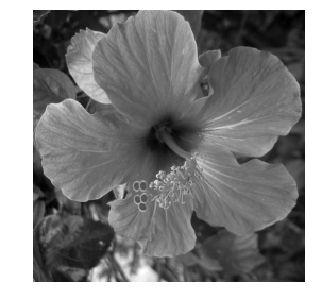

In [4]:
plt.figure(figsize = (5,5))
imageplot(f0)

Standard deviation $\si$ of the noise.

In [5]:
sigma = .08

Then we add Gaussian noise $w$ to obtain $f=f_0+w$.

In [6]:
from numpy import random
f = f0 + sigma*random.standard_normal((n,n))

Display the noisy image. Note the use of the clamp function to force the result to be in $[0,1]$ to avoid a loss of contrast of the display.

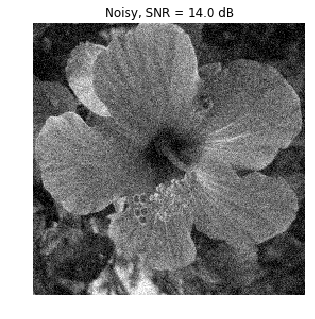

In [7]:
plt.figure(figsize = (5,5))
imageplot(clamp(f), "Noisy, SNR = %.1f dB" %snr(f0, f))

The Stein Unbiased Risk Estimator (SURE) associated to the mapping $h$
is defined as

$$ \text{SURE}(f) = -N\si^2 + \norm{h(f)-f}^2 + 2\si^2 \text{df}(f) $$

where df stands for _degree of freedom,_ and is defined as

$$ \text{df}(f) = \text{div} h(f) = \sum_i \pd{h}{f_i}(f). $$


It has been introduced in:


Stein, Charles M. (November 1981).
"Estimation of the Mean of a Multivariate Normal Distribution".
The Annals of Statistics 9 (6): 1135-1151.


And it has been applied to wavelet-based non-linear denoising in:


Donoho, David L.; Iain M. Johnstone (December 1995).
"Adapting to Unknown Smoothness via Wavelet Shrinkage".
Journal of the American Statistical Association (Journal of the American Statistical Association,
Vol. 90, No. 432) 90 (432): 1200-1244.


If the mapping $f \mapsto h(f)$ is differentiable outside a set of
zero measure (or more generally weakly differentiable),
then SURE defines an unbiased estimate of the quadratic risk :

$$ \EE_W(\text{SURE}(F)) = \EE_W( \norm{f_0-h(F)}^2 ). $$

This is especially useful, since the evaluation of SURE does not
necessitate the knowledge of the clean signal $f_0$ (but note however
that it requires the knowledge of the noise level $\si$).


In practice, one replaces $\text{SURE}(F)$ from its empirical
evaluation $\text{SURE}(f)$ on a single realization $f$.
One can then minimize $\text{SURE}(f)$ with respect to a parameter
$\la$ that parameterizes the denoiser $h=h_\la$.


Linear Denoising SURE
---------------------
We consider a translation-invariant linear denoising operator, which is
thus a convolution

$$ h(f) = f \star g $$

where $g \in \RR^N$ is a low pass kernel, and $\star$ denotes the
periodic 2-D convolution.


Since we use periodic boundary condition, we compute the
convolution as a multiplication over the Fourier domain.

$$ \forall \om, \quad \hat h(f)(\om) = \hat f(\om) \hat g(\om) $$

where $\hat g(\om)$ is the frequency $\om$ of the discrete 2-D
Fourier transform of $g$ (computed using the pylab function fft2 from the pylab package).

In [8]:
convol = lambda f,g: np.real(pyl.ifft2(pyl.fft2(f)*np.tile(pyl.fft2(g), (1,1))))

We define a parameteric kernel $g_\la$ parameterized by its bandwidth
$\la>0$. We use here a Gaussian kernel

$$ g_\la(a) = \frac{1}{Z_\la} e^{ -\frac{\norm{a}}{2 \la^2} } $$
where $Z_\la$ ensures that $\sum_a g_\la(a) = 1$.

In [9]:
normalize = lambda f: f/np.sum(f)
x = np.hstack((np.arange(0,n//2+1),np.arange(-n//2 + 1,0)))
[Y, X] = np.meshgrid(x, x)
g = lambda lambd: normalize(np.exp(-(X**2 + Y**2)/(2*lambd**2)))

Define our denoising operator $h=h_\la$ (we make explicit the
dependency on $\la$):
$$ h_\la(f) = g_\la \star f. $$

In [10]:
h = lambda f, lambd: convol(f, g(lambd))

Example of denoising result.

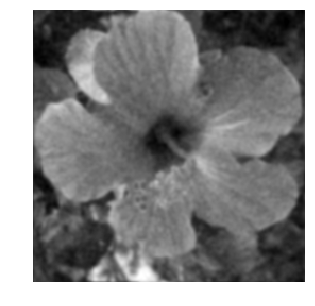

In [11]:
lambd = 1.5

plt.figure(figsize = (5,5))
imageplot(clamp(h(f, lambd)))

For linear operator, the dregree of freedom is equal to the trace of the operator, and
thus in our case it is equal to the sum of the Fourier transform
$$ \text{df}_\la(f) = \text{tr}(h_\la) = \sum_{\om} \hat g_\la(\om) $$
Note that we have made explicit the dependency of df with respect
to $\la$. Note also that df$(f)$ actually not actually depend on $f$.

In [12]:
df = lambda lambd: np.real(np.sum(pyl.fft2(g(lambd))))

We can now define the SURE=SURE$_\la$ operator, as a function of $f, h(f),
\lambda$.

In [13]:
from numpy import linalg
SURE = lambda f,hf,lambd: -N*sigma**2 + linalg.norm(hf-f,"fro")**2 + 2 * sigma**2 * df(lambd)

__Exercise 1__

For a given $\lambda$, display the histogram of the repartition of
the quadratic error $\norm{y-h(y)}^2$ and of $\text{SURE}(y)$.
Compute these repartition using Monte-Carlo simulation (you need to
generate lots of different realization of the noise $W$).
Display in particular the location of the mean of these quantities.

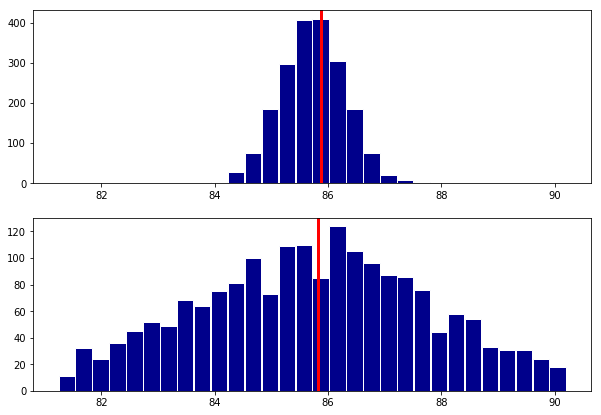

<Figure size 432x288 with 0 Axes>

In [14]:
run -i nt_solutions/denoisingadv_9_sure/exo1

In [15]:
## Insert your code here.

In practice, the SURE is used to set up the value of $\la$ from a
single realization $f=f_0+w$, by minimizing $\text{SURE}_\la(f)$.

__Exercise 2__

Compute, for a single realization $f=f_0+w$, the evolution
of

$$ E(\la) = \text{SURE}_\la(f) \qandq E_0(\lambda) = \norm{f-h_\la(f)}^2 $$
as a function of $\lambda$.

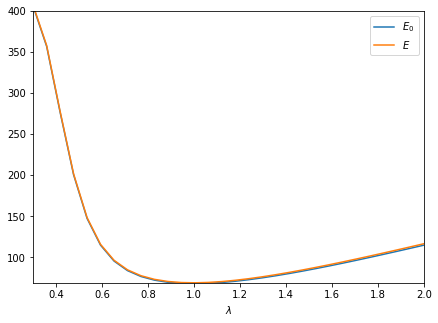

In [16]:
run -i nt_solutions/denoisingadv_9_sure/exo2

In [17]:
## Insert your code here.

__Exercise 3__

Display the best denoising result $h_{\la^*}(f)$
where
$$\la^* = \uargmin{\la} \text{SURE}_\la(f) $$

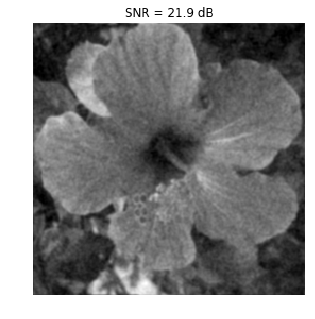

In [18]:
run -i nt_solutions/denoisingadv_9_sure/exo3

In [19]:
## Insert your code here.

Soft Thresholding SURE
----------------------
In order to enhance the denoising results for piecewise regular signal
and image, it is possible to use non-linear thresholding in an orthogonal wavelet
basis $ \Bb = \{ \psi_m \}_{m} $ where $\psi_m \in \RR^N$ is a wavelet element.


Re-generate a noisy image.

In [20]:
f = f0 + sigma*random.standard_normal((n,n))

The soft-thresholding estimator thus reads
$$ h_\la(f) = \sum_m s_\la( \dotp{f}{\psi_m} ) \psi_m
      \qwhereq s_\la(\al) = \max\pa{0, 1-\frac{\la}{\abs{\al}}} \al. $$
It can be conveniently written as
$$ h_\la = \Ww^* \circ S_\la \circ \Ww $$
where $\Ww$ and $\Ww^*$ are forward and inverse wavelet transform
$$ \Ww(f) = ( \dotp{f}{\psi_m} )_m \qandq
      \Ww^*(x) = \sum_m x_m \psi_m, $$
and $ S_\la $ is the diagonal soft thresholding operator
$$ S_\la(x) = ( s_\la(x_m) )_m. $$


Define the wavelet transform and its inverse.

In [21]:
from nt_toolbox.compute_wavelet_filter import *

h_daub = compute_wavelet_filter('Daubechies',4) 
W  = lambda f1: perform_wavortho_transf(f1,0,+1,h_daub)
Ws = lambda x: perform_wavortho_transf(x,0,-1,h_daub)

Display the wavelet transform $\Ww(f_0)$ of the original image.

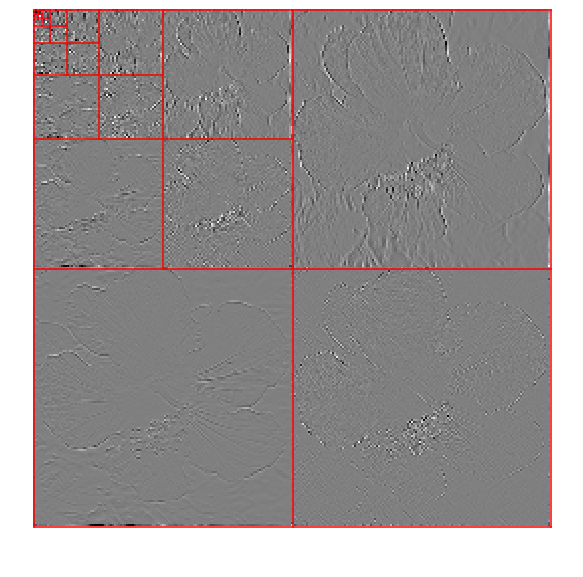

In [22]:
plt.figure(figsize = (10,10))
plot_wavelet(W(f0), 1)
plt.show()

Define the soft thresholding operator.

In [23]:
S = lambda x,lambd: np.maximum(np.zeros(list(np.shape(x))), 1-lambd/np.maximum(1e-9*np.ones(list(np.shape(x))),abs(x)))*x

Define the denoising operator.

In [24]:
h = lambda f1,lambd: Ws(S(W(f1), lambd))

Example of denoising result.

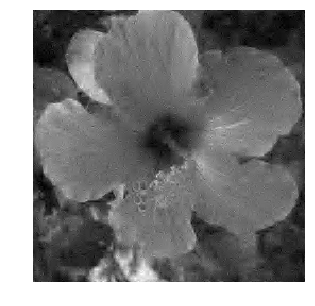

In [25]:
lambd = 3*sigma/2

plt.figure(figsize = (5,5))
imageplot(clamp(h(f,lambd)))

Since $Ww$ is an orthogonal transform, one has
$$ \text{df}(f) = \text{div}( S_\la )( \Ww(f) )
      = \sum_m s_\la'( \dotp{f}{\psi_m} ) = \norm{\Ww(h(f))}_0  $$
where $ s_\la' $ is the derivative of the 1-D function $s_\la$, and
$\norm{\cdot}_0$ is the $\ell^0$ pseudo-norm
$$ \norm{x}_0 = \abs{ \enscond{m}{x_m \neq 0} }. $$


To summarize, the degree of freedom is equal to the number of non-zero
coefficients in the wavelet coefficients of $h(f)$.

In [26]:
df = lambda hf,lambd : np.sum(abs(W(hf)) > 1e-8)

We can now define the SURE operator, as a function of $f, h(f),
\lambda$.

In [27]:
SURE = lambda f,hf,lambd: -N*sigma**2 + linalg.norm(hf-f, 'fro')**2 + 2*sigma**2*df(hf, lambd)

__Exercise 4__

For a given $\lambda$, display the histogram of the repartition of
the quadratic error $\norm{y-h(y)}^2$ and of $\text{SURE}(y)$.
Compute these repartition using Monte-Carlo simulation (you need to
generate lots of different realization of the noise $W$).
Display in particular the location of the mean of these quantities.
_Hint:_ you can do the computation directly over the wavelet domain,
i.e. consider that the noise is added to the wavelet transform.

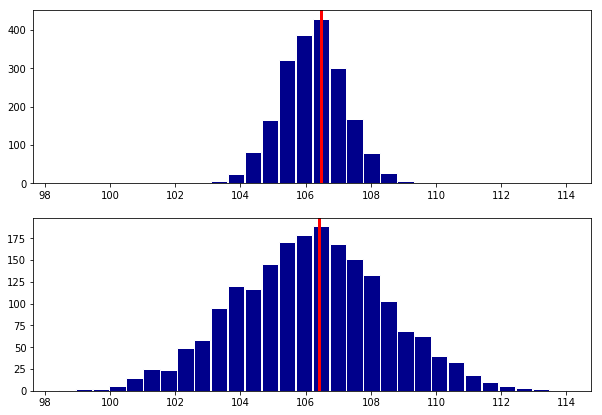

<Figure size 432x288 with 0 Axes>

In [28]:
run -i nt_solutions/denoisingadv_9_sure/exo4

In [29]:
## Insert your code here.

__Exercise 5__

Compute, for a single realization $f=f_0+w$, the evolution
of

$$ E(\la) = \text{SURE}_\la(f) \qandq E_0(\lambda) = \norm{f-h_\la(f)}^2 $$
as a function of $\lambda$.

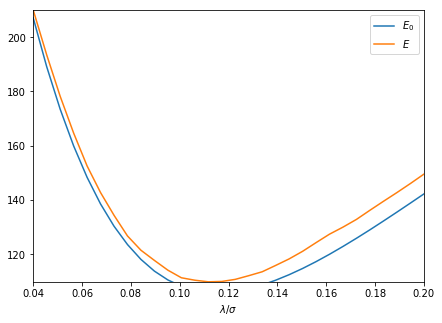

In [30]:
run -i nt_solutions/denoisingadv_9_sure/exo5

In [31]:
## Insert your code here.

__Exercise 6__

Display the best denoising result $h_{\la^*}(f)$
where
$$\la^* = \uargmin{\la} \text{SURE}_\la(f) $$

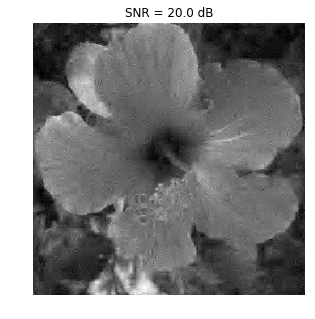

In [32]:
run -i nt_solutions/denoisingadv_9_sure/exo6

In [33]:
## Insert your code here.

Block-soft Thresholding SURE
----------------------------
To improve the result of soft thresholding, it is possible to threshold
blocks of coefficients.


We define a partition $ \{1,\ldots,N\} = \cup_k b_k $ of the set of wavelet
coefficient indexes. The block thresholding is defined as

$$ h_\la(f) = \sum_k \sum_{m \in b_k} a_\la( e_k ) \dotp{f}{\psi_m} \psi_m
      \qwhereq
      e_k = \sum_{m \in b_k} \abs{\dotp{f}{\psi_m}}^2,
$$
where we use the James-Stein attenuation threshold
$$
      a_\la(e) = \max\pa{ 0, 1 - \frac{\la^2}{e^2} }.
$$


The block size $q$.

In [34]:
q = 4

A function to extract blocks.

In [35]:
[X,Y,dX,dY] = np.meshgrid(np.arange(1,n-q+2,q),np.arange(1,n-q+2,q),np.arange(0,q),np.arange(0,q))
I = (X + dX - 1) + (Y + dY - 1)*n

for i in range(n//q):
    for j in range(n//q):
        I[i,j] = np.transpose(I[i,j])
        
blocks = lambda fw : np.ravel(fw)[I]

A function to reconstruct an image from blocks.

In [36]:
def assign(M,I,H):
    M_temp = M
    np.ravel(M_temp)[I] = H
    return np.reshape(M_temp,(n,n))

unblock = lambda H : assign(np.zeros([n,n]), I, H)

Compute the average energy of each block, and duplicate.

In [37]:
def energy(H):
    H_tmp = np.copy(H)
    for i in range(n//q):
        for j in range(n//q):
            H_tmp[i][j] = np.mean(H_tmp[i][j]**2)*np.ones([q,q])
    return H_tmp

Threshold the blocks. We use here a Stein block thresholding.
All values within a block are atenuated by the same factor.

In [38]:
S = lambda H,lambd : np.maximum(1-lambd**2/energy(H), np.zeros(np.shape(H)))*H

Block thresholding estimator $h_\lambda(f)$.

In [39]:
h = lambda f,lambd: Ws(unblock(S(blocks(W(f)), lambd)))

Example of block denoising.

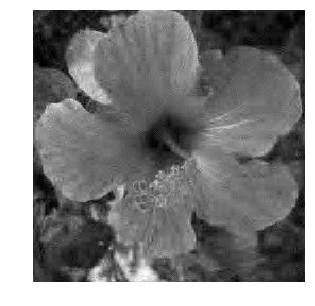

In [40]:
lambd = 1.1*sigma

plt.figure(figsize = (5,5))
imageplot(clamp(h(f, lambd)))

Since the block-thresholding operates in a block diagonal manner over the
wavelet coefficients, it degree of freedom is a sum of the divergence of
each block James-Stein operator
$$
  \text{df}(f) = \sum_{ e_k > \la^2 } \text{tr}( \partial \phi (a_k) )
$$
where $ a_k = (\dotp{f}{\psi_m})_{m \in b_k} $ is the set of coefficients
inside a block, that satisfies $\norm{a_k}=e_k$, and
where
$$ \phi(a) = \pa{ 1 - \frac{\la^2}{\norm{a}^2} } a. $$
One can compute explicitely the derivative of $\phi$
$$ \partial \phi(a) = \pa{ 1 - \frac{\la^2}{\norm{a}^2} } \text{Id} + 2 \frac{\la^2}{\norm{a}^2} \Pi_a $$
where $\Pi_a$ is the orthogonal projector on $a$.


This gives the folowing formula for the degree of freedom
$$
  \text{df}(f) = \norm{\Ww(h_\la(f))}_0
+ \sum_{ e_k > \la^2 }
  \frac{\la^2}{e_k} (2-\abs{b_k}).
$$
One can note that the degree of freedom differs from the one of the soft thresholding
(it is not in general an integer).